In [106]:
#pip install git+https://github.com/scikit-bio/scikit-bio.git

In [107]:
import seaborn as sns
import pandas as pd
import os
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import numpy as np
import warnings
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from scipy.signal import savgol_filter
from scipy.spatial.distance import euclidean
from skbio.stats.composition import clr
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler

In [108]:
# @title Data Reading


gene_count_path ='/content/drive/MyDrive/MITResearch/IBD_13/gene_count_preprocessed.csv'
metaphlan_path = '/content/drive/MyDrive/MITResearch/IBD_13/metaphlan_preprocessed.csv'

gene_count_df = pd.read_csv(gene_count_path)
metaphlan_df = pd.read_csv(metaphlan_path)

print(gene_count_df.shape)
print(metaphlan_df.shape)

(605, 547)
(479, 1454)


In [109]:
gene_count_df.head()

,PatientID_Weeknr,patient_id,week,Flare_status,ABCA1_ENSG00000165029_ENST00000678995,ABCA8_ENSG00000141338_ENST00000586539,ABCB1_ENSG00000085563_ENST00000622132,ACKR3_ENSG00000144476_ENST00000272928,ACTB_ENSG00000075624_ENST00000674681,ACVR1B_ENSG00000135503_ENST00000257963,...,IFNL1_ENSG00000182393_ENST00000333625,IL2_ENSG00000109471_ENST00000226730,IL9_ENSG00000145839_ENST00000274520,IRGM_ENSG00000237693_ENST00000522154,KDR_ENSG00000128052_ENST00000263923,LCN2_ENSG00000148346_ENST00000373017,MUC19_ENSG00000205592_ENST00000454784,NLRP7_ENSG00000167634_ENST00000588756,ORMDL3_ENSG00000172057_ENST00000394169,TSLP_ENSG00000145777_ENST00000344895
0,TR_2101_W01,TR_2101,1,Pre_flare,0.303834,0.0,4.249298,0.163413,0.163413,0.635312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TR_2101_W02,TR_2101,2,Pre_flare,1.080434,0.0,1.964692,0.019465,0.227558,0.889905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TR_2101_W03,TR_2101,3,Pre_flare,0.310896,0.0,0.947843,0.114711,0.000000,0.474833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TR_2101_W05,TR_2101,5,Pre_flare,1.494467,0.0,1.300247,0.000000,0.000000,0.323139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TR_2101_W06,TR_2101,6,Pre_flare,0.292919,0.0,1.609222,0.081657,0.000000,0.354465,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
# @title align_flare_start_function
def align_flare_start_week(df, flare_column='Flare_start', week_column='week', patient_column='patient_id', target_week=0):
    """
    Adjusts the week numbers for each patient in the dataframe such that the first occurrence
    of Flare_start=1 (that is not the first sample for the patient) occurs in the same target week for all patients who have a flare start.

    Args:
    df (pd.DataFrame): DataFrame containing the data.
    flare_column (str): Column name indicating the flare start.
    week_column (str): Column name indicating the week number.
    patient_column (str): Column name indicating the patient ID.
    target_week (int): The week number to which the first flare start should be aligned.

    Returns:
    pd.DataFrame: Modified DataFrame with adjusted week numbers.
    """
    df = df.copy()
    adjusted_dfs = []

    # Add a column indicating if the patient had a flare or not
    df['had_flare'] = df.groupby(patient_column)[flare_column].transform('max')

    for patient in df[patient_column].unique():
        patient_data = df[df[patient_column] == patient].copy()
        first_week = patient_data[week_column].min()

        if patient_data['had_flare'].iloc[0] == 1:
            # Identify flare weeks and remove the first week if it's a flare
            flare_weeks = patient_data[patient_data[flare_column] == 1][week_column]
            flare_weeks = flare_weeks[flare_weeks > first_week]  # ignore flare at the first recorded week

            if not flare_weeks.empty:
                flare_week = flare_weeks.min()  # first flare that's not at the first week
                shift = target_week - flare_week
                patient_data[week_column] += shift

        adjusted_dfs.append(patient_data)

    aligned_df = pd.concat(adjusted_dfs, ignore_index=True)

    # Normalize to ensure there are no negative weeks
    min_week = aligned_df[week_column].min()
    if min_week < 0:
       aligned_df.loc[aligned_df['had_flare'] == 1, week_column] -= min_week

    # Remove the temporary 'had_flare' column before returning
    aligned_df.drop('had_flare', axis=1, inplace=True)

    return aligned_df

In [111]:
# @title flag_first_flare_weeks function

def flag_first_flare_weeks(df):
    # Identify the rows where flare starts
    df['is_flare'] = (df['Flare_status'] == 'During_flare') | (df['Flare_status'] == 'During_flare_2')

    # Sort by patient and week to ensure the chronological order
    df.sort_values(by=['patient_id', 'week'], inplace=True)

    # Mark each flare start for each patient
    df['Flare_start'] = (df['is_flare']) & (df['is_flare'] != df['is_flare'].shift(1))

    # Convert boolean to integer (1 for True, 0 for False)
    df['Flare_start'] = df['Flare_start'].astype(int)

    flare_start = df.pop('Flare_start')
    # Now, insert it at the desired position
    df.insert(3, 'Flare_start', flare_start)

    # Drop helper columns if they are no longer needed
    df.drop('is_flare', axis=1, inplace=True)

    return df

In [112]:
# @title calculate_alpha_diversity function

def calculate_alpha_diversity(df, diversity_index='shannon'):
    """Calculate alpha diversity based on the specified diversity index."""
    if diversity_index == 'shannon':
        return df.apply(lambda x: entropy(x[x > 0]), axis=1)
    elif diversity_index == 'simpson':
        def simpson_index(x):
            x = x[x > 0]
            if len(x) == 0:
                return np.nan
            p = x / x.sum()
            return 1 - np.sum(p**2)
        return df.apply(simpson_index, axis=1)
    elif diversity_index == 'richness':
        return df.apply(lambda x: (x > 0).sum(), axis=1)
    elif diversity_index == 'evenness':
        # Calculate evenness using Pielou's evenness index
        def pielou_evenness(x):
            x = x[x > 0]
            if len(x) == 0:
                return np.nan
            shannon = entropy(x)
            richness = np.log(len(x))
            if richness == 0:
                return np.nan  # Avoid division by zero
            return shannon / richness
        return df.apply(pielou_evenness, axis=1)
    else:
        raise ValueError("Unsupported diversity index specified.")


In [113]:
# @title smooth_patient_data
def smooth_patient_data(df, value_columns, patient_column='patient_id', week_column='week'):
    """
    Smooths the values of the specified columns in the dataframe using a rolling window average.

    Args:
    df (pd.DataFrame): DataFrame containing the data to be smoothed.
    value_columns (list): List of columns to smooth.
    patient_column (str): Column name for patient ID.
    week_column (str): Column name for week number.

    Returns:
    pd.DataFrame: Smoothed DataFrame.
    """
    df = df.copy()
    smoothed_dfs = []

    for patient in df[patient_column].unique():
        patient_data = df[df[patient_column] == patient].copy()
        patient_data = patient_data.sort_values(by=week_column)

        for col in value_columns:
            smoothed_values = patient_data[col].rolling(window=3, min_periods=1, center=True).mean()
            # Handle first and last weeks separately
            if len(smoothed_values) > 1:
                smoothed_values.iloc[0] = patient_data[col].iloc[:2].mean()
                smoothed_values.iloc[-1] = patient_data[col].iloc[-2:].mean()
            patient_data[col] = smoothed_values

        smoothed_dfs.append(patient_data)

    smoothed_df = pd.concat(smoothed_dfs)
    return smoothed_df


In [114]:
#  @title  calculate aitchison distance for consecutive samples

def calculate_aitchison_distance_consecutive(df, species_cols):
    results = []

    for patient in df['patient_id'].unique():
        patient_data = df[df['patient_id'] == patient].copy()
        patient_data = patient_data.sort_values(by='week')

        patient_data['clr_transformed'] = patient_data[species_cols].apply(lambda row: clr(row), axis=1)

        for i in range(len(patient_data) - 1):
            week_current = patient_data.iloc[i]['week']
            week_next = patient_data.iloc[i + 1]['week']

            clr_current = patient_data.iloc[i]['clr_transformed']
            clr_next = patient_data.iloc[i + 1]['clr_transformed']

            aitchison_dist = euclidean(clr_current, clr_next)
            results.append({
                'patient_id': patient,
                'week_current': week_current,
                'week_next': week_next,
                'aitchison_distance': aitchison_dist,
                'Flare_start': patient_data.iloc[i]['Flare_start']
            })

    return pd.DataFrame(results)



In [217]:
# @title plot_aitchison_distance_consecutive
def plot_aitchison_distance_consecutive(aitchison_df):
    patients_with_flare = aitchison_df[aitchison_df['Flare_start'] == 1]['patient_id'].unique()
    patients_without_flare = aitchison_df[~aitchison_df['patient_id'].isin(patients_with_flare)]['patient_id'].unique()

    fig, axs = plt.subplots(1, 2, figsize=(40, 10))

    # Plot for patients with flare
    ax = axs[0]
    sns.lineplot(data=aitchison_df[aitchison_df['patient_id'].isin(patients_with_flare)],
                 x='week_next', y='aitchison_distance', hue='patient_id',  ax=ax)

    flare_starts = aitchison_df[aitchison_df['Flare_start'] == 1]
    ax.scatter(flare_starts['week_next'], flare_starts['aitchison_distance'],
                color='red', s=50, zorder=5, label='Flare Start')

    ax.set_title('Beta Diversity (Aitchison Distance) Over Time for Patients with Flare')
    ax.set_xlabel('Week')
    ax.set_ylabel('Aitchison Distance')
    all_weeks = aitchison_df['week_next'].unique()
    ax.set_xticks(all_weeks)
    ax.set_xticklabels(all_weeks, rotation=45)
    ax.legend(title='Patient ID', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    major_ticks = range(0, max(all_weeks) + 1, 5)  # Get unique weeks
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_ticks, rotation=45)
    ax.grid(False)



    # Plot for patients without flare
    ax = axs[1]
    sns.lineplot(data=aitchison_df[aitchison_df['patient_id'].isin(patients_without_flare)],
                 x='week_next', y='aitchison_distance', hue='patient_id', ax=ax)
    ax.set_title('Beta Diversity (Aitchison Distance) Over Time for Patients without Flare')
    ax.set_xlabel('Week')
    ax.set_ylabel('Aitchison Distance')
    all_weeks = aitchison_df['week_next'].unique()
    ax.set_xticks(all_weeks)
    ax.set_xticklabels(all_weeks, rotation=45)
    ax.legend(title='Patient ID', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    major_ticks = range(0, 55, 5)  # Get unique weeks
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_ticks, rotation=45)
    ax.grid(False)


    plt.tight_layout()
    plt.show()

In [263]:
# @title plot_aitchison_distance_to_core

def plot_aitchison_distance_to_core(distance_df, patients_with_flare, patients_without_flare):
    fig, axs = plt.subplots(1, 2, figsize=(40, 10))  # Adjust figsize as needed

    # Plot for patients with flare
    ax = axs[0]
    sns.lineplot(data=distance_df[distance_df['patient_id'].isin(patients_with_flare)],
                 x='week', y='aitchison_distance', hue='patient_id', ax=ax)

    flare_starts = distance_df[distance_df['Flare_start'] == 1]
    ax.scatter(flare_starts['week'], flare_starts['aitchison_distance'], color='red', s=50, zorder=5, label='Flare Start')

    ax.set_title('Aitchison Distance to Core Microbiome Over Time for Patients with Flare')
    ax.set_xlabel('Week')
    ax.set_ylabel('Aitchison Distance')

    # Add trend line using polynomial regression
    all_weeks = distance_df[distance_df['patient_id'].isin(patients_with_flare)]['week']
    all_distances = distance_df[distance_df['patient_id'].isin(patients_with_flare)]['aitchison_distance']
    if not all_weeks.empty and not all_distances.empty:
        z = np.polyfit(all_weeks, all_distances, 3)
        p = np.poly1d(z)
        x_range = np.linspace(all_weeks.min(), all_weeks.max(), 100)
        ax.plot(x_range, p(x_range), label='Trend line', color="red", linestyle="--")

    # Remove axes spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Create legend with no box and sorted alphabetically
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    sorted_labels = sorted(by_label.keys())
    ax.legend(title='Patients', bbox_to_anchor=(1.05, 1), loc='upper left', handles=[by_label[l] for l in sorted_labels], labels=sorted_labels, frameon=False)


    # Determine y-ticks based on the first plot's y-range
    y_max = round(distance_df['aitchison_distance'].max())
    y_ticks = range(0, y_max+1, 10)

    major_ticks = range(0, all_weeks.max() + 1, 5)  # Get unique weeks
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_ticks, rotation=45)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks)
    ax.grid(False)



    # Plot for patients without flare
    ax = axs[1]
    sns.lineplot(data=distance_df[distance_df['patient_id'].isin(patients_without_flare)],
                 x='week', y='aitchison_distance', hue='patient_id', ax=ax)

    ax.set_title('Aitchison Distance to Core Microbiome Over Time for Patients without Flare')
    ax.set_xlabel('Week')
    ax.set_ylabel('Aitchison Distance')

    # Add trend line using polynomial regression
    all_weeks = distance_df[distance_df['patient_id'].isin(patients_without_flare)]['week']
    all_distances = distance_df[distance_df['patient_id'].isin(patients_without_flare)]['aitchison_distance']
    if not all_weeks.empty and not all_distances.empty:
        z = np.polyfit(all_weeks, all_distances, 3)
        p = np.poly1d(z)
        x_range = np.linspace(all_weeks.min(), all_weeks.max(), 100)
        ax.plot(x_range, p(x_range), label='Trend line', color="red", linestyle="--")

    # Remove axes spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)


    # Create legend with no box and sorted alphabetically
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    sorted_labels = sorted(by_label.keys())
    ax.legend(title='Patients', bbox_to_anchor=(1.05, 1), loc='upper left', handles=[by_label[l] for l in sorted_labels], labels=sorted_labels, frameon=False)

    major_ticks = range(0, all_weeks.max() + 1, 5)  # Get unique weeks
    ax.set_xticks(major_ticks)
    ax.set_xticklabels(major_ticks, rotation=45)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks)
    ax.grid(False)

    plt.tight_layout()
    plt.show()


In [116]:
# @title compute_core_metaphlan
def compute_core_metaphlan(metaphlan_df, flare_column='Flare_start', week_column='week', patient_column='patient_id'):
    """
    Computes the average microbial abundances for each patient using only the samples before the flare starts.

    Args:
    metaphlan_df (pd.DataFrame): DataFrame containing microbial abundance data with 'patient_id', 'week', and 'Flare_start' columns.
    flare_column (str): Column name indicating the flare start.
    week_column (str): Column name indicating the week number.
    patient_column (str): Column name indicating the patient ID.

    Returns:
    pd.DataFrame: A new DataFrame with the average microbial abundances for each patient before the flare starts.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    metaphlan_copy = metaphlan_df.copy()

    # Select columns with species data

    species_cols = [col for col in metaphlan_copy.columns if col.startswith('s__')]

    # Initialize a list to store the core microbial abundances
    core_metaphlan_list = []

    for patient in metaphlan_copy[patient_column].unique():
        # Get the data for the current patient
        patient_data = metaphlan_copy[metaphlan_copy[patient_column] == patient]

        # Find the week when the flare starts
        flare_week = patient_data[patient_data[flare_column] == 1][week_column].min()

        if (pd.isna(flare_week) or flare_week==0):
            # If there's no flare start, use all the data
            pre_flare_data = patient_data
        else:
            # Filter the data to include only the samples before the flare starts
            pre_flare_data = patient_data[patient_data[week_column] < flare_week]

        # Calculate the average microbial abundances
        avg_abundances = pre_flare_data[species_cols].mean()

        # Add patient information
        avg_abundances[patient_column] = patient
        core_metaphlan_list.append(avg_abundances)

    # Create a DataFrame from the list
    core_metaphlan = pd.DataFrame(core_metaphlan_list)

    # Reorder columns to have patient_id first
    core_metaphlan = core_metaphlan[[patient_column] + species_cols]

    return core_metaphlan

In [117]:
# @title aitchison_distance
def aitchison_distance(x, y):
    x_clr = np.log(x) - np.mean(np.log(x))
    y_clr = np.log(y) - np.mean(np.log(y))
    return euclidean(x_clr, y_clr)

In [193]:
# @title calculate_aitchison_distance_to_core
def calculate_aitchison_distance_to_cor(metaphlan_df, core_metaphlan):
    metaphlan_copy = metaphlan_df.copy()
    species_cols = [col for col in metaphlan_copy.columns if col.startswith('s__')]

    # Replace zero values with the minimum positive value divided by two
    metaphlan_copy[species_cols] = metaphlan_copy[species_cols].replace(0, np.nan)
    min_positive_value = metaphlan_copy[species_cols].min().min() / 2
    metaphlan_copy[species_cols] = metaphlan_copy[species_cols].fillna(min_positive_value)

    distances = []
    for patient in metaphlan_copy['patient_id'].unique():
        patient_data = metaphlan_copy[metaphlan_copy['patient_id'] == patient].sort_values(by='week')
        core_values = core_metaphlan[core_metaphlan['patient_id'] == patient][species_cols].values.flatten()
        for week in patient_data['week'].unique():
            week_data = patient_data[patient_data['week'] == week][species_cols].values.flatten()
            distance = aitchison_distance(week_data, core_values)
            distances.append({'patient_id': patient, 'week': week, 'aitchison_distance': distance, 'Flare_start': patient_data[patient_data['week']==week]['Flare_start'].item()})

    distance_df = pd.DataFrame(distances)
    return distance_df

In [120]:
# @title Adding a Flare_start column
metaphlan_df = flag_first_flare_weeks(metaphlan_df)
gene_count_df = flag_first_flare_weeks(gene_count_df)

In [121]:
# @title plot species abundance over time

def plot_species_abundance_over_time(df, cols_to_plot, title, type_, selection_mode='user'):
    """
    Plots the abundance over time for the specified species for each patient in the dataframe in a single figure with subplots.

    Args:
    df (pd.DataFrame): DataFrame containing microbial abundance data.
    cols_to_plot (list or None): List of species names to plot, or None if to be determined by selection_mode.
    title (str): Title for the plots and y-axis label.
    type_ (str): Label for the plot legend.
    selection_mode (str): Mode of selecting columns ('user', 'variation', 'mean'). 'user' expects cols_to_plot to be provided.
    """
    unique_patients = df['patient_id'].unique()
    num_patients = len(unique_patients)
    cols = 2  # Number of columns for subplots
    rows = (num_patients // cols) + (num_patients % cols > 0)  # Calculate rows needed

    fig, axs = plt.subplots(rows, cols, figsize=(20, 5 * rows))  # Adjust figsize as needed
    axs = axs.flatten()  # Flatten in case of 2D array of axes

    for i, patient in enumerate(unique_patients):
        ax = axs[i]
        patient_data = df[df['patient_id'] == patient].copy()
        patient_data.sort_values(by='week', inplace=True)  # Ensure data is sorted by week

        # Exclude non-abundance columns to focus on species data
        species_data = patient_data.drop(exclude_columns, axis=1)

        # Determine columns to plot based on selection_mode if cols_to_plot is None or selection_mode is not 'user'
        if cols_to_plot is None or selection_mode != 'user':
            if selection_mode == 'variation':
                # Find the x species with the highest standard deviation
                cols_to_plot = species_data.std().sort_values(ascending=False).head(6).index.tolist()
            elif selection_mode == 'top1':
                top_species = set()  # Use a set to avoid duplicates
                for index, row in species_data.iterrows():
                    top_species.update(row.nlargest(1).index)
                cols_to_plot = list(top_species)  # Convert set to list
            elif selection_mode == 'mean':
                # Find the x species with the highest mean
                cols_to_plot = species_data.mean().sort_values(ascending=False).head(6).index.tolist()

        # Plot the abundance over time for the specified species
        for species in cols_to_plot:
            if species in species_data.columns:
                sns.lineplot(data=patient_data, x='week', y=species, label=species, ax=ax)

        # Annotate flare status changes (if applicable)
        flare_changes = patient_data.drop_duplicates('Flare_status', keep='first')[['week', 'Flare_status']]
        for _, (week, status) in flare_changes.iterrows():
            ax.axvline(x=week, color='grey', linestyle='--')
            ax.text(week, ax.get_ylim()[1], f' {status}', verticalalignment='top', fontsize=8)

        # Setting x-axis ticks for every week, adjusting label rotation for clarity
        major_ticks = range(55)[::5]  # Get unique weeks
        ax.set_xticks(major_ticks)
        ax.set_xticklabels(major_ticks, rotation=45)

        ax.set_title(f'{title} Over Time for Patient {patient}')
        ax.set_xlabel('Week')
        ax.set_ylabel(title)
        ax.legend(title=type_, bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(False)

        # Remove axes spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Remove legend border
    for leg in ax.get_legend().get_frame().axes.figure.legends:
        leg.get_frame().set_linewidth(0.0)

    plt.tight_layout()
    plt.show()


In [122]:
# @title shifting the week numbers so that the three patients have the beginning of their flare at the same time, which makes it easier to compare visually
metaphlan_df = align_flare_start_week(metaphlan_df)
gene_count_df = align_flare_start_week(gene_count_df)

In [123]:
gene_count_df.head()

,PatientID_Weeknr,patient_id,week,Flare_start,Flare_status,ABCA1_ENSG00000165029_ENST00000678995,ABCA8_ENSG00000141338_ENST00000586539,ABCB1_ENSG00000085563_ENST00000622132,ACKR3_ENSG00000144476_ENST00000272928,ACTB_ENSG00000075624_ENST00000674681,...,IFNL1_ENSG00000182393_ENST00000333625,IL2_ENSG00000109471_ENST00000226730,IL9_ENSG00000145839_ENST00000274520,IRGM_ENSG00000237693_ENST00000522154,KDR_ENSG00000128052_ENST00000263923,LCN2_ENSG00000148346_ENST00000373017,MUC19_ENSG00000205592_ENST00000454784,NLRP7_ENSG00000167634_ENST00000588756,ORMDL3_ENSG00000172057_ENST00000394169,TSLP_ENSG00000145777_ENST00000344895
0,TR_2101_W01,TR_2101,28,0,Pre_flare,0.303834,0.0,4.249298,0.163413,0.163413,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TR_2101_W02,TR_2101,29,0,Pre_flare,1.080434,0.0,1.964692,0.019465,0.227558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TR_2101_W03,TR_2101,30,0,Pre_flare,0.310896,0.0,0.947843,0.114711,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TR_2101_W05,TR_2101,32,0,Pre_flare,1.494467,0.0,1.300247,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TR_2101_W06,TR_2101,33,0,Pre_flare,0.292919,0.0,1.609222,0.081657,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
# @title normalize to housekeeping genes
house_keeping_genes = ["ACTB", "ATP5F1", "B2M", "GAPDH", "GUSB",
                       "HPRT", "PGK1", "PPIA", "RPS18", "TBP",
                       "TFRC", "YWHAZ"]

# Columns to exclude from normalization
exclude_columns = ['Flare_status', 'patient_id', 'week', 'Flare_start','PatientID_Weeknr']

# Normalizing the DataFrame
normalized_df = normalize_to_housekeeping_genes(gene_count_df, house_keeping_genes, exclude_columns)

In [125]:
gene_count_df.head()

,PatientID_Weeknr,patient_id,week,Flare_start,Flare_status,ABCA1_ENSG00000165029_ENST00000678995,ABCA8_ENSG00000141338_ENST00000586539,ABCB1_ENSG00000085563_ENST00000622132,ACKR3_ENSG00000144476_ENST00000272928,ACTB_ENSG00000075624_ENST00000674681,...,IFNL1_ENSG00000182393_ENST00000333625,IL2_ENSG00000109471_ENST00000226730,IL9_ENSG00000145839_ENST00000274520,IRGM_ENSG00000237693_ENST00000522154,KDR_ENSG00000128052_ENST00000263923,LCN2_ENSG00000148346_ENST00000373017,MUC19_ENSG00000205592_ENST00000454784,NLRP7_ENSG00000167634_ENST00000588756,ORMDL3_ENSG00000172057_ENST00000394169,TSLP_ENSG00000145777_ENST00000344895
0,TR_2101_W01,TR_2101,28,0,Pre_flare,33.041852,0.0,462.109167,17.771035,17.771035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TR_2101_W02,TR_2101,29,0,Pre_flare,882.236990,0.0,1604.284785,15.894673,185.814036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TR_2101_W03,TR_2101,30,0,Pre_flare,264.457715,0.0,806.264473,97.576583,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TR_2101_W05,TR_2101,32,0,Pre_flare,1300.666089,0.0,1131.632530,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TR_2101_W06,TR_2101,33,0,Pre_flare,247.927420,0.0,1362.051591,69.114687,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
metaphlan_df.columns

Index(['PatientID_Weeknr', 'patient_id', 'week', 'Flare_start', 'Flare_status',
       's__GGB39918_SGB47522', 's__Actinobaculum_sp_oral_taxon_183',
       's__Actinomyces_SGB17154', 's__Actinomyces_SGB17168',
       's__Actinomyces_bouchesdurhonensis',
       ...
       's__GGB48567_SGB66627', 's__Lentilactobacillus_parabuchneri',
       's__GGB9355_SGB14328', 's__GGB1550_SGB2134', 's__GGB4586_SGB6344',
       's__GGB3341_SGB4420', 's__Clostridium_sp_OM07_10AC',
       's__GGB6569_SGB9281', 's__GGB9636_SGB15107', 's__GGB4599_SGB6362'],
      dtype='object', length=1455)

In [127]:
#plot_alpha_diversity_over_time(metaphlan_df.drop('PatientID_Weeknr', axis=1),  'Alpha Diversity Indices')

In [128]:
#plot_alpha_diversity_over_time(metaphlan_df.drop('PatientID_Weeknr', axis=1), smooth=True)

In [129]:
# @title Remove dominant species
# # Step 1: Compute mean relative abundances for each species per patient
# species_columns = [col for col in metaphlan_df.columns if col.startswith('s__')]
# mean_abundances = metaphlan_df.groupby('patient_id')[species_columns].mean()

# # Step 2: Identify species to zero out
# species_to_zero = mean_abundances.apply(lambda x: x > 0.07)

# # Step 3: Set values to zero for identified species
# for patient in species_to_zero.index:
#     for species in species_columns:
#         if species_to_zero.at[patient, species]:
#             metaphlan_df.loc[metaphlan_df['patient_id'] == patient, species] = 0

# # Step 4: Normalize the DataFrame so that each row sums to 1
# metaphlan_df[species_columns] = metaphlan_df[species_columns].div(metaphlan_df[species_columns].sum(axis=1), axis=0)

microbes to investigate

In [130]:
metaphlan_df = flag_first_flare_weeks(metaphlan_df)
gene_count_df = flag_first_flare_weeks(gene_count_df)

<ipython-input-111-5c666a94bec8>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['is_flare'] = (df['Flare_status'] == 'During_flare') | (df['Flare_status'] == 'During_flare_2')
<ipython-input-111-5c666a94bec8>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(3, 'Flare_start', flare_start)


In [131]:
metaphlan_df.filter(regex=r'^s__Blautia').columns

Index(['s__Blautia_SGB4805', 's__Blautia_SGB4815', 's__Blautia_SGB4831',
       's__Blautia_argi', 's__Blautia_caecimuris', 's__Blautia_faecicola',
       's__Blautia_faecis', 's__Blautia_glucerasea', 's__Blautia_hansenii',
       's__Blautia_hydrogenotrophica', 's__Blautia_massiliensis',
       's__Blautia_obeum', 's__Blautia_producta', 's__Blautia_sp_AF19_10LB',
       's__Blautia_sp_An249', 's__Blautia_sp_An81', 's__Blautia_sp_MSK_20_85',
       's__Blautia_sp_MSK_21_1', 's__Blautia_sp_OF03_15BH',
       's__Blautia_stercoris', 's__Blautia_wexlerae', 's__Blautia_luti',
       's__Blautia_sp_Marseille_P3087', 's__Blautia_schinkii',
       's__Blautia_SGB15070', 's__Blautia_marasmi',
       's__Blautia_sp_Marseille_P3201T', 's__Blautia_SGB4793'],
      dtype='object')

In [132]:
species_columns = [col for col in metaphlan_df.columns if col.startswith('s__')]
gene_columns = [col for col in gene_count_df.columns if col not in ['patient_id', 'week', 'Flare_status', 'Flare_start', 'ts', 'RBF', 'ts_patient_id']]

In [165]:

extended_colors = [
    '#66c2a5',  # Teal
    '#ff7f00',  # Orange
    '#8da0cb',  # Light Blue
    '#e78ac3',  # Pink
    '#a6d854',  # Light Green
    '#e5c494',  # Tan
    '#b3b3b3',  # Gray
    '#80b1d3',  # Sky Blue
    '#bebada',  # Lavender
    '#fb8072',  # Light Red
    '#7fc97f',  # Medium Green
    '#d9d9d9',  # Light Gray
    '#ffed6f',  # Pale Yellow
    '#b15928',  # Brown
    '#fccde5',  # Pale Pink
    '#8dd3c7',  # Pale Teal
    '#ffffb3',  # Very Pale Yellow
    '#bc80bd'   # Purple
]

# Set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=extended_colors)

# Set other default styles
#plt.rcParams['figure.facecolor'] = '#f0f0f0'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#cccccc'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.5

# Adjust grid frequency
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['axes.grid.axis'] = 'both'


# Set default line width
plt.rcParams['lines.linewidth'] = 1.2

plt.rcParams.update({'font.size': 22})

# Beta Diversity Aitchison

In [173]:
# Create a copy of the DataFrame to avoid modifying the original
aitchison_df = metaphlan_df.copy()

# Select columns with species data
exclude_cols = ['patient_id', 'week', 'Flare_status', 'Flare_start', 'ts', 'RBF', 'ts_patient_id', 'PatientID_Weeknr']
species_cols = [col for col in aitchison_df.columns if col not in exclude_cols]

# Find the minimum positive value in the species data
min_positive_value = aitchison_df[species_cols][aitchison_df[species_cols] > 0].min().min()

# Replace zeros with the minimum positive value divided by two
replacement_value = min_positive_value / 2
aitchison_df[species_cols] = aitchison_df[species_cols].replace(0, replacement_value)

# Calculate Aitchison distance
to_plot_aitchison_df = calculate_aitchison_distance_consecutive(aitchison_df, species_cols)

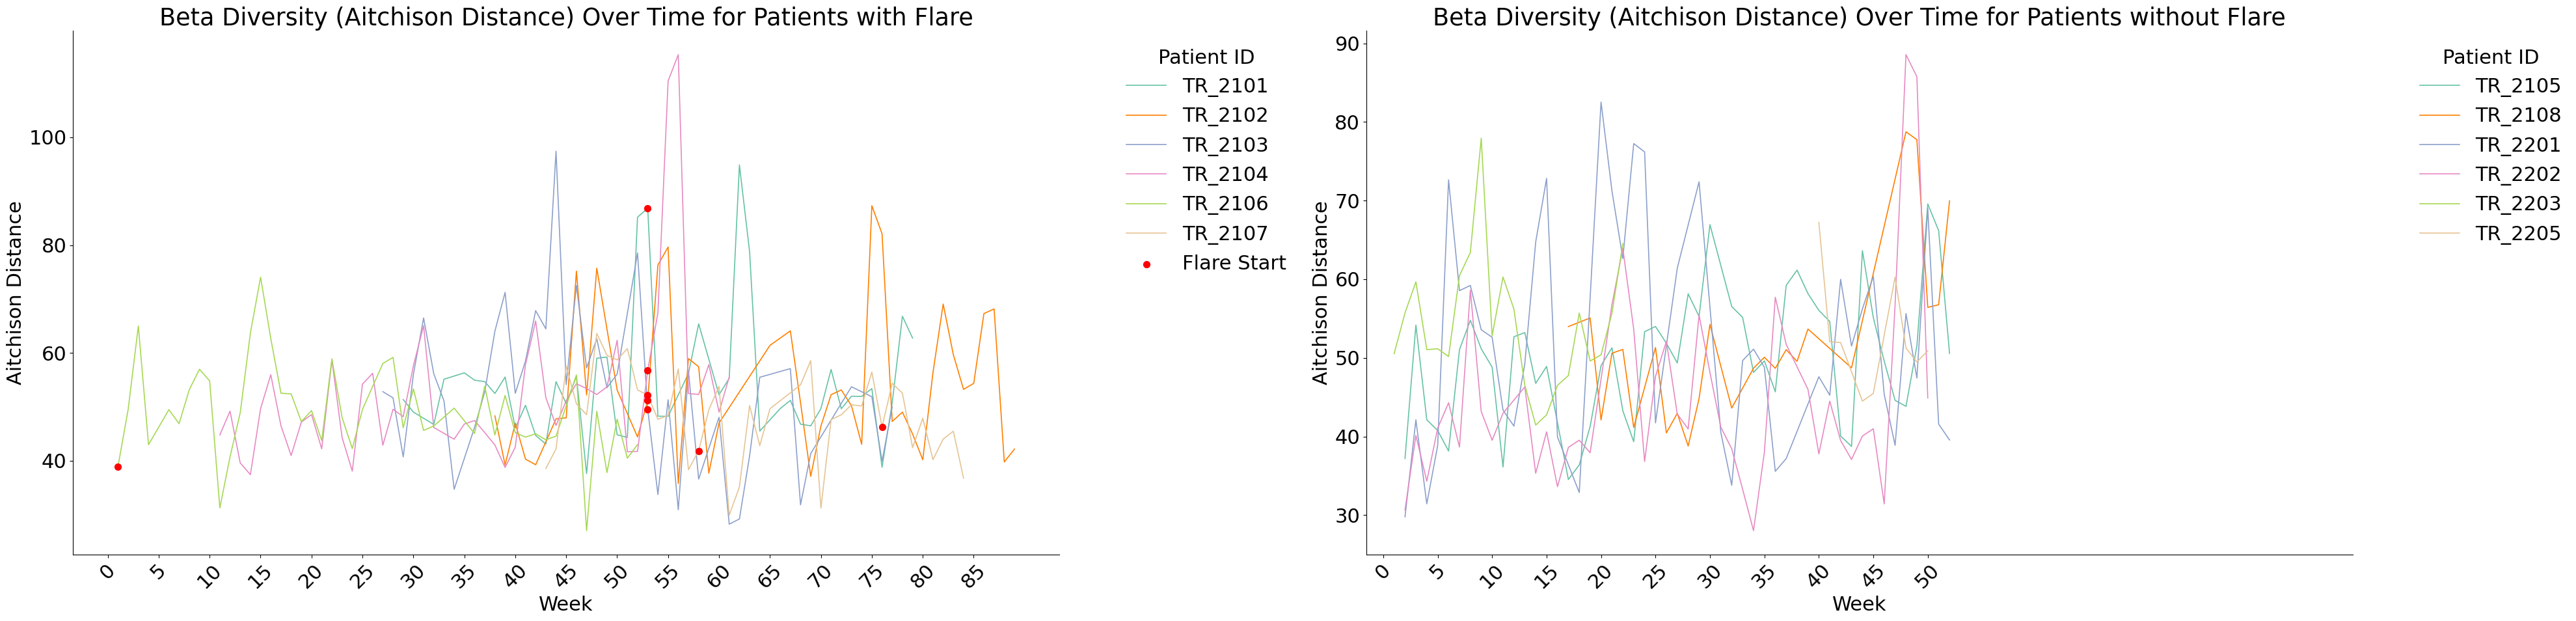

In [247]:
plot_aitchison_distance_consecutive(to_plot_aitchison_df)

In [195]:
core_metaphlan = compute_core_metaphlan(aitchison_df.drop('PatientID_Weeknr', axis=1))

# Example usage of calculate_aitchison_distances
distance_df = calculate_aitchison_distance_to_cor(metaphlan_df.drop('PatientID_Weeknr', axis=1), core_metaphlan)

# Separate patients into those with and without flare
patients_with_flare = metaphlan_df[metaphlan_df['Flare_start'] == 1]['patient_id'].unique()
patients_without_flare = metaphlan_df[~metaphlan_df['patient_id'].isin(patients_with_flare)]['patient_id'].unique()


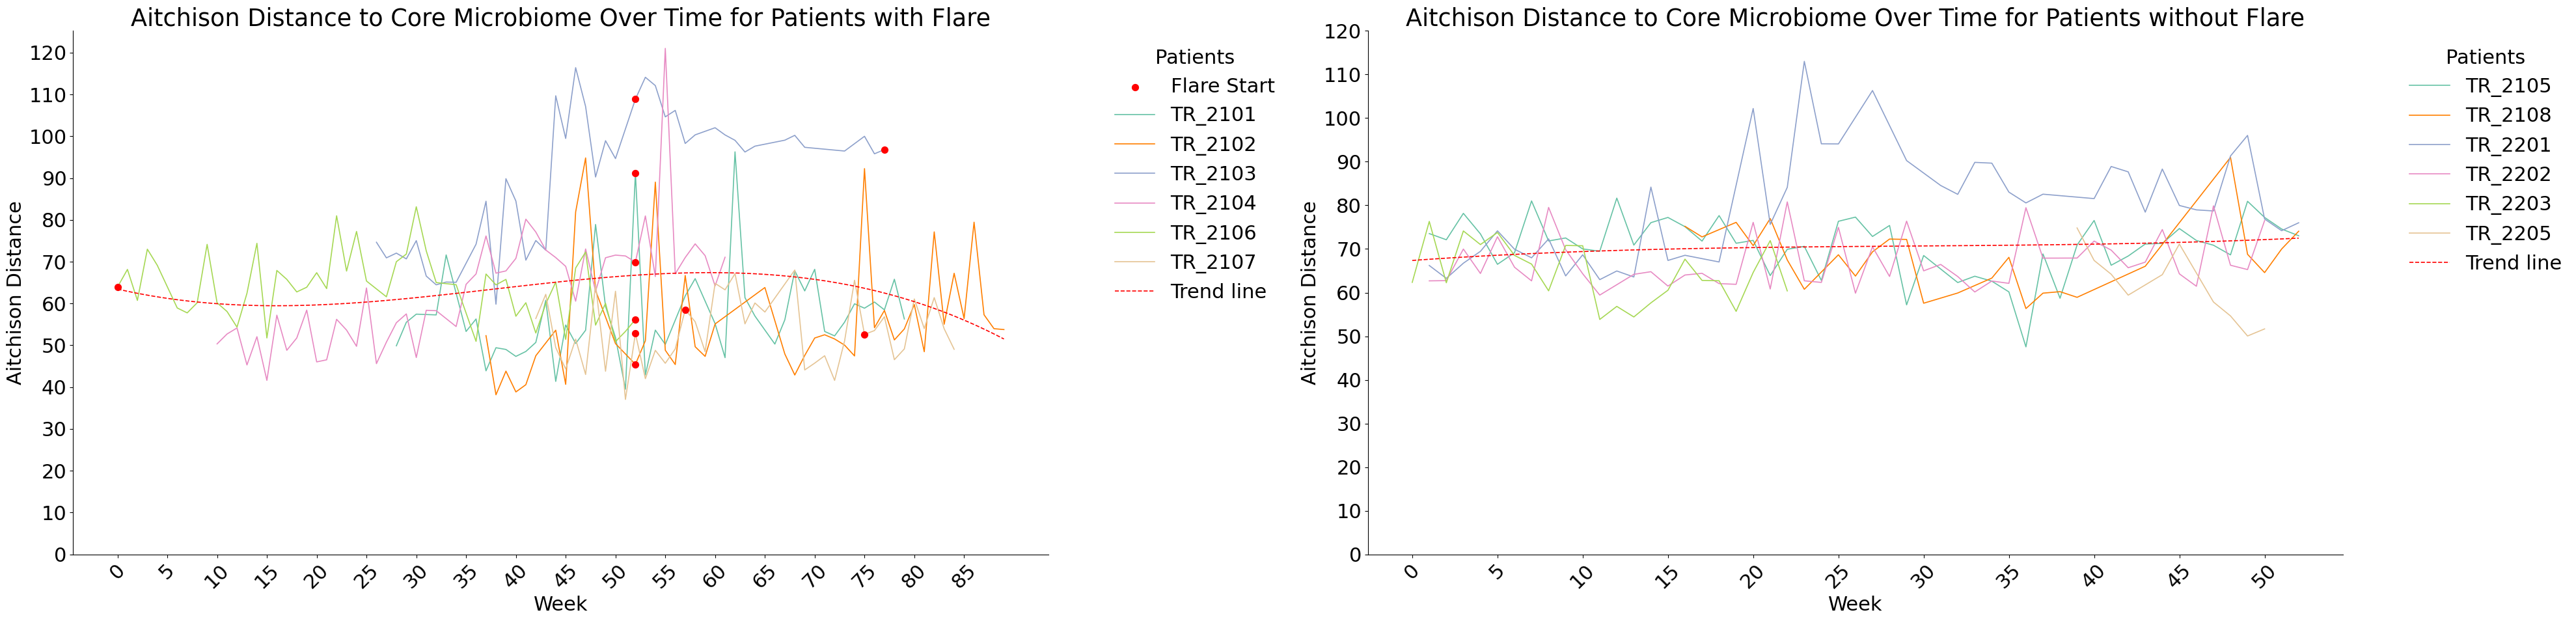

In [264]:
# # Plotting
# Example usage of plot_aitchison_distance
plot_aitchison_distance_to_core(distance_df, patients_with_flare, patients_without_flare)

In [ ]:
plot_aitchison_distance_to_core(smooth_patient_data(distance_df, ['aitchison_distance']), patients_with_flare, patients_without_flare, metaphlan_df[metaphlan_df['Flare_start'] == 1]['week'].unique())

In [ ]:
metaphlan_df.head()

In [ ]:
gene_count_df.head()

In [ ]:
# Save the dataframes as CSV files
metaphlan_df.to_csv('metaphlan_df.csv', index=False)
gene_count_df.to_csv('gene_count_df.csv', index=False)

In [ ]:
#plot_alpha_diversity_over_time(metaphlan_df.drop('PatientID_Weeknr', axis=1), smooth=False)